In [1]:
import trimesh, glob, pathlib, random, traceback

In [2]:
# Get all collision obj files
all_files = set(pathlib.Path(x) for x in glob.glob(r"D:\ig_pipeline\artifacts\aggregate\objects\*\*\shape\visual\*.obj"))

In [3]:
import logging
logger = logging.getLogger("trimesh")
logger.setLevel(logging.ERROR)

In [4]:
import tempfile, shutil, subprocess, os
VHACD_EXECUTABLE = "/svl/u/gabrael/v-hacd/app/build/TestVHACD"

def get_vhacd_mesh(file_bytes, hull_count):
    with tempfile.TemporaryDirectory() as td:
        in_path = os.path.join(td, "in.obj")
        out_path = os.path.join(td, "decomp.obj")  # This is the path that VHACD outputs to.
        with open(in_path, 'wb') as f:
            f.write(file_bytes)
        vhacd_cmd = [str(VHACD_EXECUTABLE), in_path, "-r", "1000000", "-d", "20", "-v", "60", "-h", str(hull_count)]
        try:
            proc = subprocess.run(vhacd_cmd, shell=False, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, cwd=td, check=True)
            return trimesh.load(out_path, file_type="obj", force="mesh", skip_textures=True)
        except subprocess.CalledProcessError as e:
            raise ValueError(f"VHACD failed with exit code {e.returncode}. Output:\n{e.output}")


In [5]:
def binary_search(x, f, low, high):
    mid = 0
 
    while low <= high:
        mid = (high + low) // 2
        val = f(mid)
        if val < x:
            low = mid + 1
        elif val > x:
            high = mid - 1
        else:
            return mid
    return low

In [6]:
import numpy as np
import trimesh.voxel.creation
import io

def voxelize(m):
    pitch = 0.01
    return trimesh.voxel.creation.local_voxelize(
        m, pitch=pitch, point=np.array([0, 0, 0]),
        radius=int(np.ceil(0.5/pitch))
    ).matrix

def analyze_object(visual_content):
    # First, run VHACD on the full thing with 128 hulls as an upper bound
    max_mesh = get_vhacd_mesh(visual_content, 128)
    translation = -np.mean(max_mesh.bounds, axis=0)
    scale = np.min(1 / max_mesh.extents)
    matrix_1 = trimesh.transformations.scale_matrix(scale)
    matrix_2 = trimesh.transformations.translation_matrix(translation)
    matrix = matrix_1 @ matrix_2
    max_mesh.apply_transform(matrix)  
    v_max_mesh = voxelize(max_mesh)

    # Define a binary-searchable function to find the best entry
    with tempfile.TemporaryDirectory() as td:
        memory = {}
        def compute_iou(hull_count):
            hull_count_mesh = get_vhacd_mesh(visual_content, hull_count)
            out_fn = pathlib.Path(td) / f"{hull_count}.obj"
            hull_count_mesh.export(str(link_obj_path), file_type="obj")
            hull_count_mesh.apply_transform(matrix)
            v_hull_count_mesh = voxelize(hull_count_mesh)

            # Compute their intersection volume
            intersection = v_max_mesh & v_hull_count_mesh
            intersection_cnt = np.count_nonzero(intersection)
            union = v_max_mesh | v_hull_count_mesh
            union_cnt = np.count_nonzero(union)
            iou = intersection_cnt / union_cnt

            memory[hull_count] = (out_fn, iou)

            return iou
        
        # Then, start binary search on the hull count to find the lowest entry above 0.85
        lowest_acceptable_hull_count = binary_search(0.85, compute_iou, 1, 64)
        
        # Return the contents of the lowest acceptable hull count file
        lowest_acceptable_hull_file = memory[lowest_acceptable_hull_count]
        with open(lowest_acceptable_hull_file, "rb") as f:
            return f.read()

def load_analyze_object(client, visual_fn):
    # Load the visual mesh
    assert visual_fn.exists(), str(visual_fn)
    with open(visual_fn, "rb") as f:
        visual_content = f.read()
           
    # Now call analyze object
    return client.submit(analyze_object, visual_content, key=str(visual_fn)).result()

In [7]:
from dask.distributed import Client

dask_client = Client('sc.stanford.edu:35423', direct_to_workers=True)

C:\Users\Cem\.conda\envs\pipeline\lib\site-packages\distributed\client.py:1361: VersionMismatchWarning: Mismatched versions found

+-------------+--------+-----------+---------+
| Package     | Client | Scheduler | Workers |
+-------------+--------+-----------+---------+
| cloudpickle | 2.1.0  | 2.2.1     | 2.2.1   |
| lz4         | 4.3.2  | None      | None    |
| numpy       | 1.22.3 | 1.24.2    | 1.24.2  |
| pandas      | 1.4.3  | None      | None    |
| tornado     | 6.1    | 6.2       | 6.2     |
+-------------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [8]:
from concurrent import futures
import tqdm

all_futures = {}
results = {}
randomized_root_files = list(all_files)
random.shuffle(randomized_root_files)
executor = futures.ThreadPoolExecutor(max_workers=100)
for rfn in tqdm.tqdm(randomized_root_files[:1000]):
    all_futures[executor.submit(load_analyze_object, dask_client, rfn)] = rfn

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 11579.02it/s]


In [21]:
print(sum(1 for f in all_futures.keys() if f.done()), "/", len(all_futures))
print(sum(1 for f in all_futures.keys() if f.done() and f.exception()), "/", len(all_futures))

304 / 1000
0 / 1000


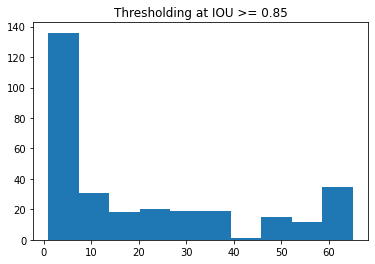

10.5 20.72222222222222 21.85808273116934


2023-02-26 23:56:41,572 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [22]:
import matplotlib.pyplot as plt
results = {rfn: f.result() for f, rfn in all_futures.items() if f.done() and not f.exception()}
vals = np.array(list(results.values()))
plt.hist(vals, bins="auto") # [1, 2, 4, 8, 16, 32, 64, 128, 256])  # arguments are passed to np.histogram
# plt.xscale("log", base=2)
plt.title(f"Thresholding at IOU >= 0.85")
plt.show()
print(np.median(vals), np.mean(vals), np.std(vals))

In [ ]:
vals

In [ ]:
if False:
    for future in all_futures.keys():
        try:
            result = future.result(timeout=0)
            rfn = all_futures[future]
            results[rfn] = result
        except:
            print("\n", all_futures[future], " ran into an error:")
            print(traceback.format_exc())

C:\Users\Cem\.conda\envs\pipeline\lib\site-packages\distributed\worker.py:2990: UserWarning: Large object of size 4.67 MiB detected in task graph: 
  (b'# https://github.com/mikedh/trimesh\r\nmtllib s ... /40591/40591',)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(
